#### 고양이의 클래스 아이디를 알아내어서 사람의 클래스 아이디에 대신 넣어서 만들 수 있다 ####

In [1]:
import cv2
import os
import numpy as np
import torch

import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

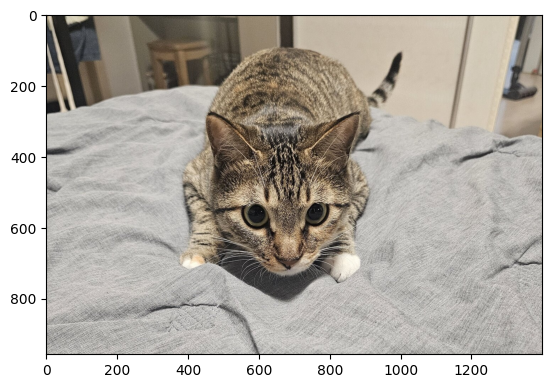

In [ ]:
#원본 이미지를 불러오고 BGR을 RGB로 변환하여 보여줍니다.
import os
import cv2
import matplotlib.pyplot as plt

img_path = "C:\\Users\\tkdwl\\AIFFEL_quest_rs\\Exploration\\Ex04\\images\\cat.jpg"
img_orig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

plt.show()

In [ ]:
##모델을 불러옵니다.
model = deeplabv3_resnet101(pretrained=True).eval()

c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 모델이 고정된 입력을 받아들이기에 그에 맞게 전처리하는 부분을 작성하고 이를 모델에 입력합니다.

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])
input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(output_predictions, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)



21

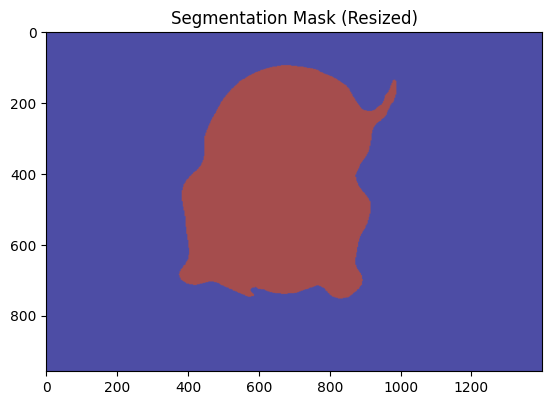

background
cat


In [ ]:
# 모델에서 출력된 세그멘테이션 마스크를 확인합니다.
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

unique_classes = np.unique(output_predictions_resized)
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

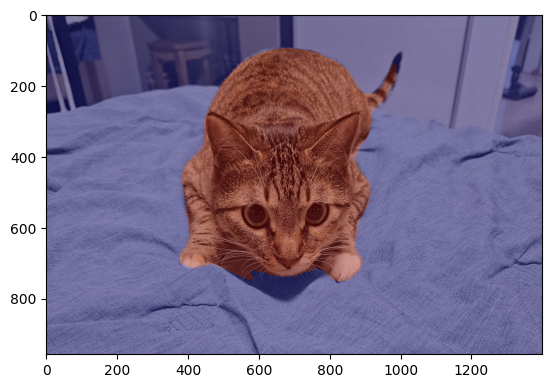

In [ ]:
# 모델에서 출력된 세그멘테이션 마스크를 확인합니다.
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력

seg_map = (output_predictions_resized == 8)  # 클래스 ID 8 (고양이)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

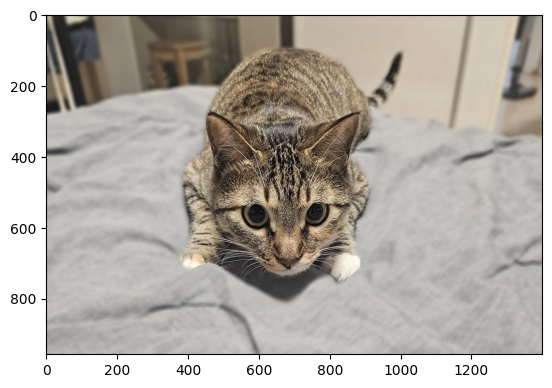

In [ ]:
# 마스크는 유지하되 배경은 블러처리를 한 이후 concat하여서 고양이에 집중된 사진을 만듭니다.

img_orig_blur = cv2.blur(img_orig, (13, 13))
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()